In [13]:
import numpy as np
import pandas as pd
import math


from src.workflow_manager.paths import data_path, ruleset_path
from src.pipelines.load_and_transform_pipeline import load_and_transform

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'
         }
pylab.rcParams.update(params)


# ML 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


from src.modelling.model_functions import build_model
from src.modelling.basemodel import base_model






pd.set_option('display.max_columns',None)


### <font color='#f88231'>Load Data and create empty Train Test split DFs</font>


In [2]:
# we need the original Data to generate the column_manager
data_original = load_and_transform(data_path, ruleset_path)

data = data_original.copy()
data['const'] = 1


# empty datasets
X_train, X_test, y_train, y_test = train_test_split(data[['contract_nr', 'const']],data[['contract_nr', 'payment_fault']].set_index('contract_nr'),test_size=0.3, random_state=42)

tts_list = [X_train, X_test, y_train, y_test ]

## <font color='#f88231'>Fit Base Model</font>


In [3]:
# Save the different columns here
column_manager = {'original' : list(data_original.columns)}
erg = build_model(data, column_manager=column_manager, group_file=base_model , tts_list=tts_list )




## <font color='#f88231'>Plotting</font>


In [71]:
# Problem: hier sind die OHCs noch nicht mit drin


def get_plot_data(erg, field_name):

    try:
        group_name = erg['column_manager']['field_to_group_map'][field_name] 
        # load Data for plotting
        plot_df = erg['prediction_testset'][['contract_nr', field_name, group_name,'payment_fault', 'predicted']].copy()
        # load factors (sigmiod)
        coefs = erg['factors'].loc[erg['factors']['field'] == field_name]
        # merge
        plot_df = pd.merge(left=plot_df, right=coefs, left_on=group_name, right_on='groups', how='left')
    except:
        # load Data for plotting
        plot_df = erg['prediction_testset'][['contract_nr', field_name, 'payment_fault', 'predicted']].copy()
        # load factors (sigmiod)
        coefs = erg['factors'].loc[erg['factors']['field'] == field_name]
        # merge
        plot_df = pd.merge(left=plot_df, right=coefs, left_on=field_name, right_on='groups', how='left')

    

    
    # group by original values
    plot_df_grp = plot_df.groupby(field_name).agg({'contract_nr':'count','payment_fault':'mean', 'predicted':'mean', 'coef':'min' }).reset_index()
    
    # Umbenennen
    plot_df_grp.columns = [x if x != 'contract_nr' else 'Exposure' for x in [field_name, 'contract_nr', 'payment_fault', 'predicted', 'coef'] ]
    return plot_df_grp




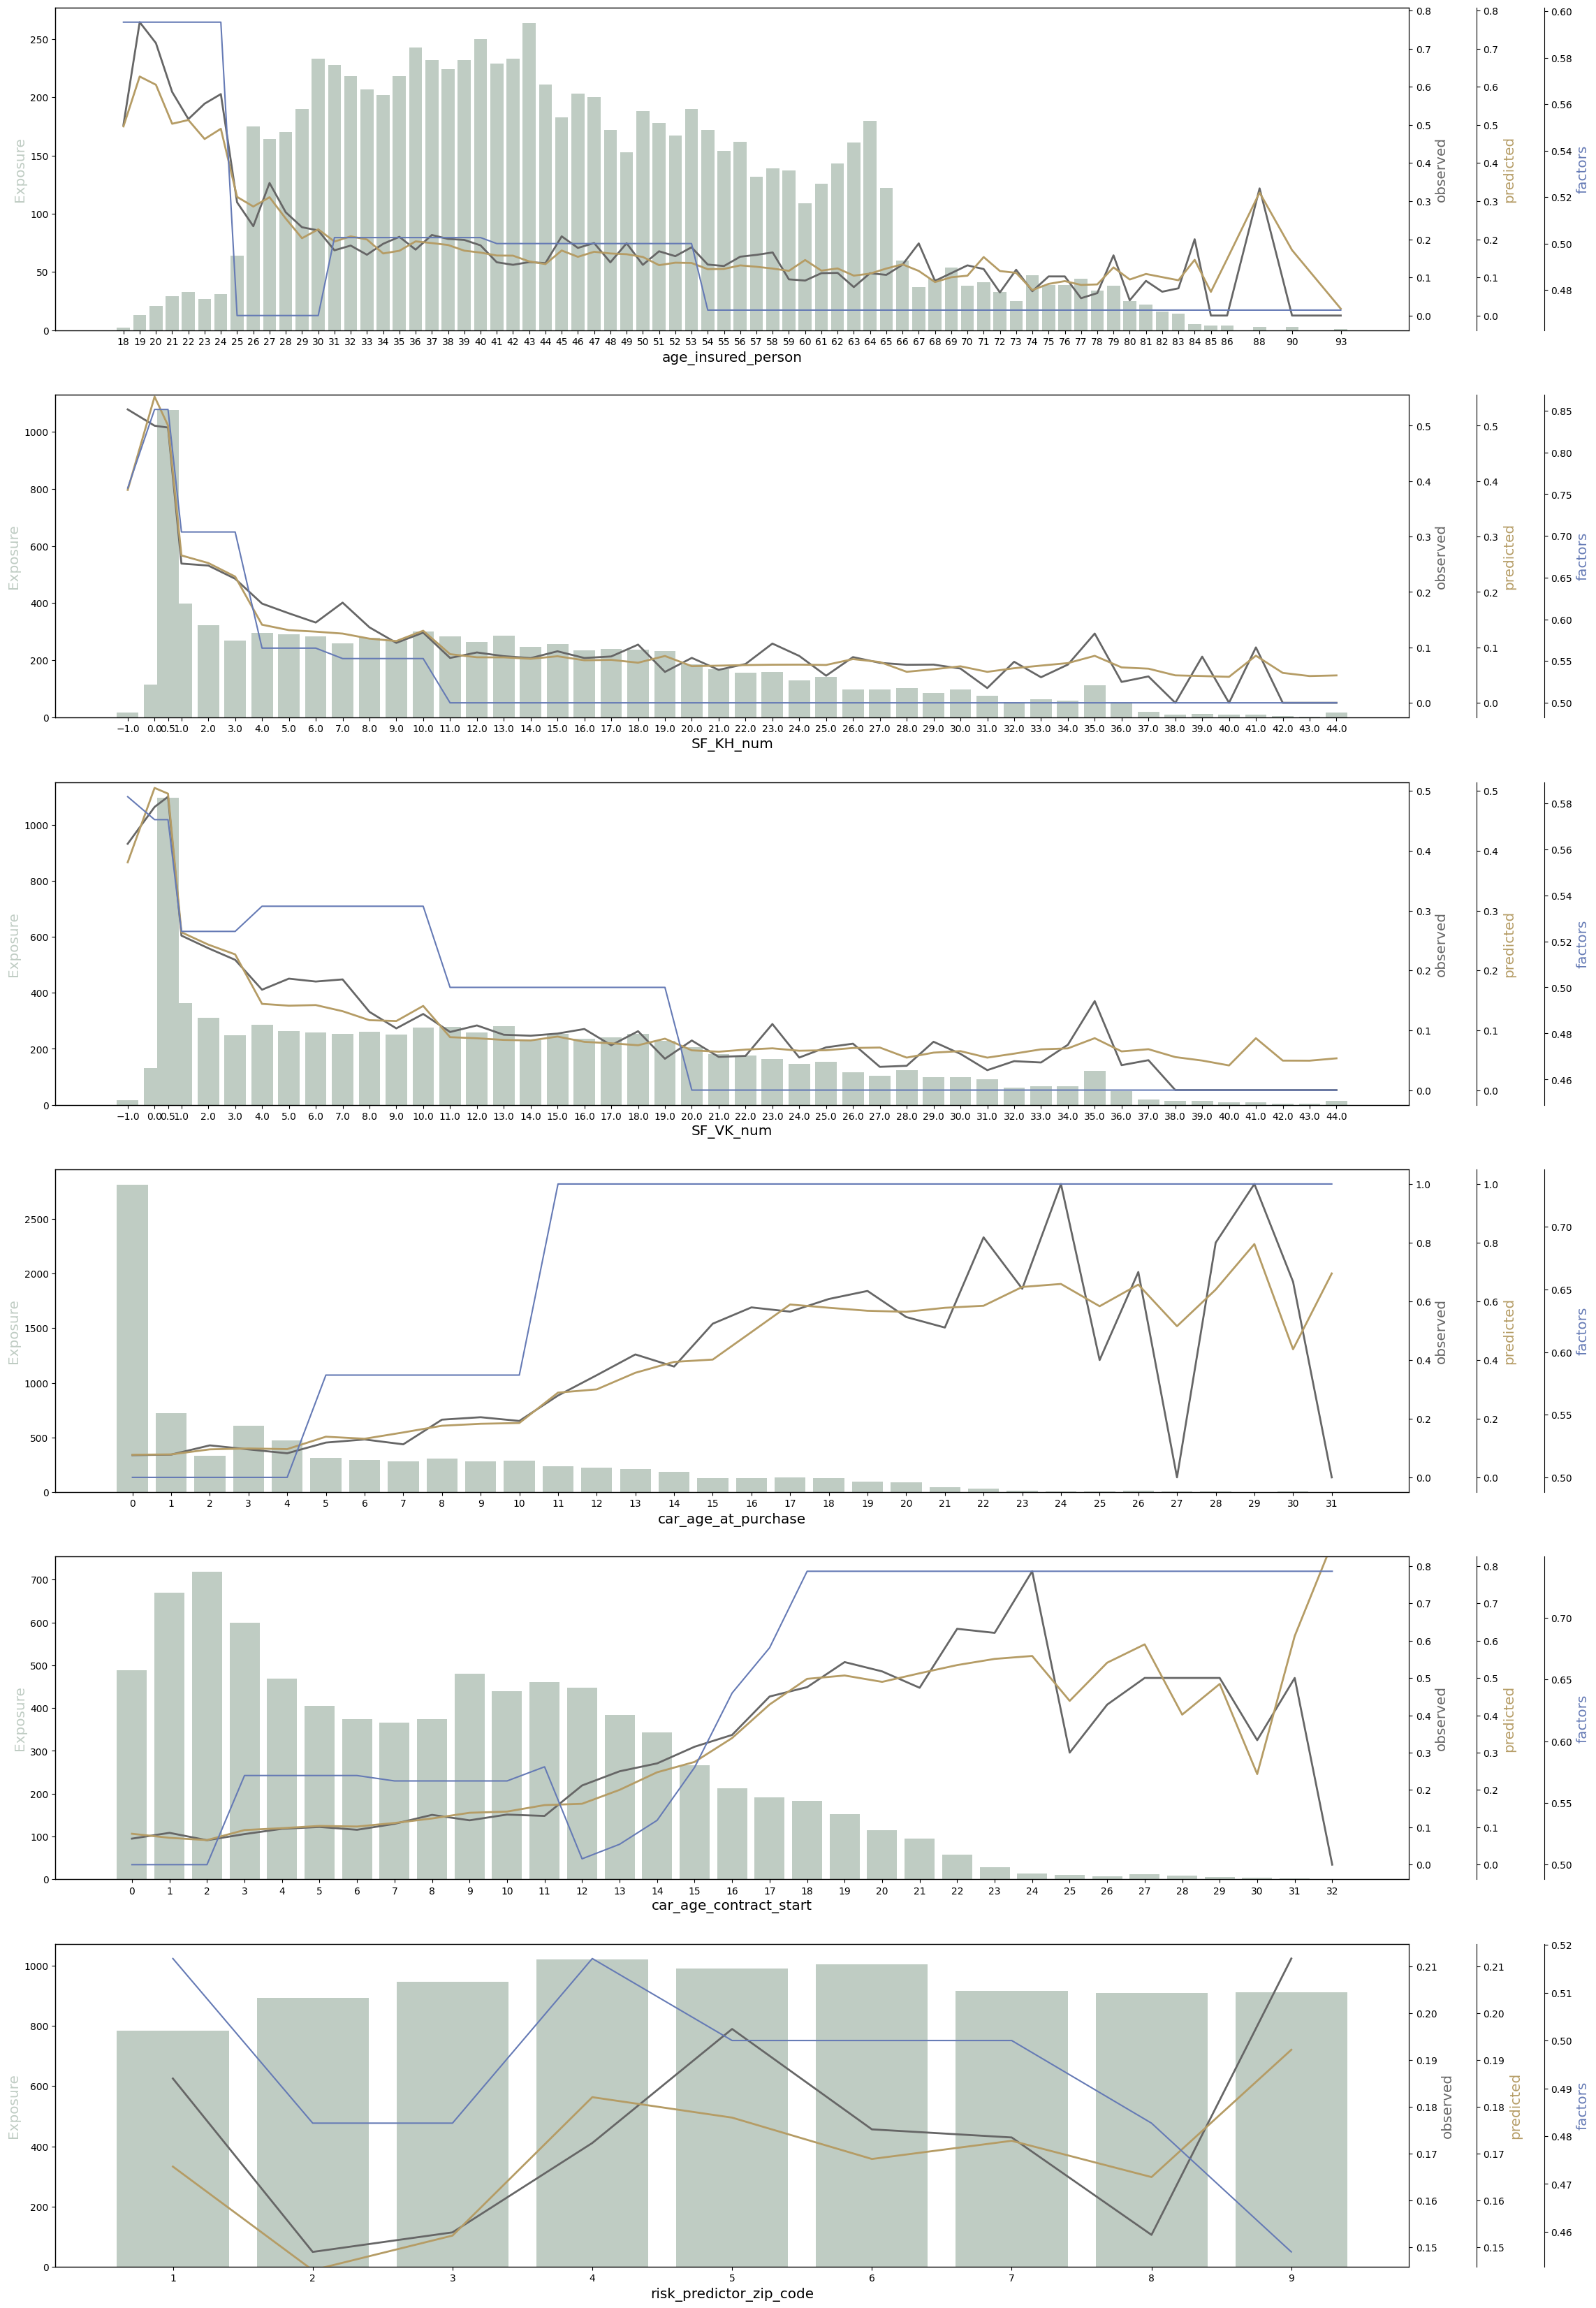

In [50]:

exp_green = '#BFCCC3' 
line_orange = '#B59C65'
line_gray = '#666666'
line_blue = '#657AB5'



def plot_model_field(erg, field_list):

    number_fields = len(field_list)


    fig, ax = plt.subplots(number_fields, 1, figsize=(25,7*number_fields))


    for i in range(number_fields):

        field_name = field_list[i]

        curr_ax = ax[i]

        plot_df_grp = get_plot_data(erg, field_name)
    
    
    
        twin1 = curr_ax.twinx()
        twin2 = curr_ax.twinx()
        twin3 = curr_ax.twinx()

        twin2.spines.right.set_position(("axes", 1.05))
        twin3.spines.right.set_position(("axes", 1.1))

        # plot Exposure and 
        curr_ax.bar(data = plot_df_grp, x=field_name , height='Exposure' , color=exp_green)
        curr_ax.set_xlabel(field_name)

        # plot observed values
        twin1.plot(plot_df_grp[field_name], plot_df_grp['payment_fault'], color=line_gray, linewidth=2)

        #plot predicted_values
        twin2.plot(plot_df_grp[field_name], plot_df_grp['predicted'], color=line_orange, linewidth=2)

        # plot the factors
        twin3.plot(plot_df_grp[field_name], plot_df_grp['coef'], color=line_blue, linewidth=1.5)




        # Labeling
        matplotlib.rc('font', weight='bold')
        curr_ax.set(ylabel='Exposure')
        curr_ax.yaxis.label.set_color(exp_green)

        twin1.set(ylabel='observed')
        twin1.yaxis.label.set_color(line_gray)

        twin2.set(ylabel='predicted', ylim = twin1.get_ylim())
        twin2.yaxis.label.set_color(line_orange)

        twin3.set(ylabel='factors')
        twin3.yaxis.label.set_color(line_blue)

        matplotlib.rc('font', weight='normal')

        #set labels 
        plt.xticks(plot_df_grp[field_name])

    plt.show()





plot_model_field(erg, list(erg['column_manager']['field_to_group_map'].keys()))

In [ ]:



    plot_df_grp = get_plot_data(erg, field_name)
    
    
    
    twin1 = ax.twinx()
    twin2 = ax.twinx()
    twin3 = ax.twinx()

    twin2.spines.right.set_position(("axes", 1.15))
    twin3.spines.right.set_position(("axes", 1.3))

    # plot Exposure and 
    ax.bar(data = plot_df_grp, x=field_name , height='Exposure' , color=exp_green)
    ax.set_xlabel("Regional Class")

    # plot observed values
    twin1.plot(plot_df_grp[field_name], plot_df_grp['payment_fault'], color=line_gray, linewidth=2)

    #plot predicted_values
    twin2.plot(plot_df_grp[field_name], plot_df_grp['predicted'], color=line_orange, linewidth=2)

    # plot the factors
    twin3.plot(plot_df_grp[field_name], plot_df_grp['coef'], color=line_blue, linewidth=1.5)




    # Labeling
    matplotlib.rc('font', weight='bold')
    ax.set(ylabel='Exposure')
    ax.yaxis.label.set_color(exp_green)

    twin1.set(ylabel='observed')
    twin1.yaxis.label.set_color(line_gray)

    twin2.set(ylabel='predicted', ylim = twin1.get_ylim())
    twin2.yaxis.label.set_color(line_orange)

    twin3.set(ylabel='factors')
    twin3.yaxis.label.set_color(line_blue)

    matplotlib.rc('font', weight='normal')

    #set labels 
    plt.xticks(plot_df_grp[field_name])

    plt.show()
